In [1]:
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Read and store databse

In [2]:
file_path = 'database/exon-intron-positions.txt'

with open(file_path, 'r') as file:
    file_contents = file.read()

#Define a regular expression to find exon and intron in the text
pattern = re.compile(r'\b(exon|intron)\s+(\d+)\.\.(\d+)')

matches = pattern.findall(file_contents)

positions_list = []

for match in matches:
    region_type, start, end = match
    positions_list.append({'type': region_type, 'start': int(start), 'end': int(end)})

#sample exon & intron positions
print('sample exon & intron positions')
print(positions_list[0:5],'\n')

file_path = 'database/genome.txt'
with open(file_path, 'r') as file:
    genome = file.read()

# Define a regular expression to find numbers in the text
cleaned_sequence = re.sub(r'[\d\s\n]', '', genome)

#sample sequence positions
print('sample sequence:')
print(cleaned_sequence[0:100])

sample exon & intron positions
[{'type': 'exon', 'start': 1960, 'end': 2580}, {'type': 'intron', 'start': 2581, 'end': 2655}, {'type': 'exon', 'start': 2656, 'end': 3030}, {'type': 'intron', 'start': 3031, 'end': 3108}, {'type': 'exon', 'start': 3109, 'end': 3255}] 

sample sequence:
cccagatacaccgctgctttgtgggcaacaacgtctcgatgtcggtgccccttgagatccacgtcgcgctctgtgggaggagaaatgccgaaactgggcg


In [3]:
def find_elements_in_string(sequence, elements):
    result = []
    for element in elements:
        start = element['start']
        end = element['end']
        element_type = element['type']
        sequence_slice = sequence[start-1:end]  # Adjusting for 0-based indexing in Python

        result.append({'type': element_type, 'sequence': sequence_slice})

    return result
result_data = find_elements_in_string(cleaned_sequence,positions_list)
df = pd.DataFrame(result_data)
print(df.head())

     type                                           sequence
0    exon  atgccggacgcgatggcctggtggaccgcctgctcgaccgacaacc...
1  intron  gtaagtgcaaaatacgctctttacttccgctcattaggcgatgtct...
2    exon  attgaagcaccgcttcccacctggctcaagacaacatcttcggacg...
3  intron  gtgagtcttccgtggccggaggtttggtagtcaggtacgtgacatt...
4    exon  gagatgatattacacagtatcagagagaacggagctggtgatgttc...


# Create Train & Test datasets

In [4]:
split_ratio = 0.8
total_rows = df.shape[0]
split_index = int(split_ratio * total_rows)
indices = np.random.permutation(total_rows)
train_indices = indices[:split_index]
test_indices = indices[split_index:]
df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

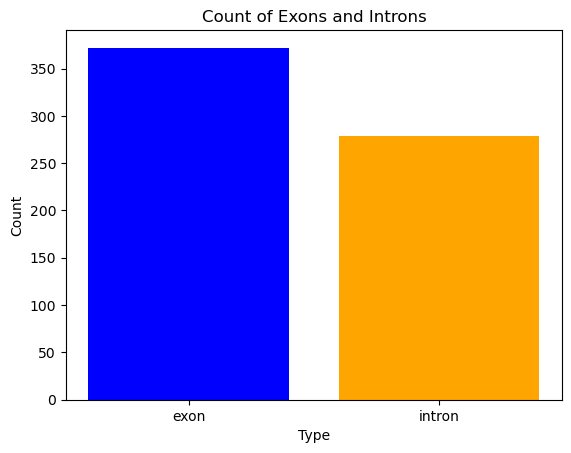

exon      372
intron    279
Name: type, dtype: int64


In [5]:
# Count the occurrences of each 'type'
type_counts = df_train['type'].value_counts()

# Plotting
plt.bar(type_counts.index, type_counts.values, color=['blue', 'orange'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of Exons and Introns')
plt.show()
print(type_counts)


# Caculating X-Contet and X-Positions

In [6]:
def calculate_parameters(df):
    result=[]
    for index, row in df.iterrows():
        counters = {
          'A1': 0, 'A2': 0, 'A3': 0,
          'C1': 0, 'C2': 0, 'C3': 0,
          'G1': 0, 'G2': 0, 'G3': 0,
          'T1': 0, 'T2': 0, 'T3': 0}
        
        sequence_type = row['type']
        sequence = row['sequence']
        n= len(sequence)
        
        #update counters
        for i in range(len(sequence)):
            position_modulo_3 = i % 3
            nucleotide = sequence[i]
            counters[f"{nucleotide.upper()}{position_modulo_3 + 1}"] += 1
            
        # Calculate X-positions
        A_Position = max(counters['A1'], counters['A2'], counters['A3']) / (min(counters['A1'], counters['A2'], counters['A3']) + 1)
        C_Position = max(counters['C1'], counters['C2'], counters['C3']) / (min(counters['C1'], counters['C2'], counters['C3']) + 1)
        G_Position = max(counters['G1'], counters['G2'], counters['G3']) / (min(counters['G1'], counters['G2'], counters['G3']) + 1)
        T_Position = max(counters['T1'], counters['T2'], counters['T3']) / (min(counters['T1'], counters['T2'], counters['T3']) + 1)
        
        #caculate X-Contents
        A_Content = sum(counters[f'A{i}'] for i in range(1, 4))/n
        C_Content = sum(counters[f'C{i}'] for i in range(1, 4))/n
        G_Content = sum(counters[f'G{i}'] for i in range(1, 4))/n
        T_Content = sum(counters[f'T{i}'] for i in range(1, 4))/n
        
        result.append({
                        'type': sequence_type,
                        'A-Position':  A_Position,
                        'C-Position':  C_Position,
                        'G-Position' : G_Position,
                        'T-Position' : T_Position,
                        'A-Content' : A_Content,
                        'C-Content' : C_Content,
                        'G-Content' : G_Content,
                        'T-Content' : T_Content
                      })
    return result

result = calculate_parameters(df_train)
df_parameters_train = pd.DataFrame(result)
print(df_parameters_train.head())


     type  A-Position  C-Position  G-Position  T-Position  A-Content  \
0  intron   13.000000    6.000000    1.800000    3.000000   0.282051   
1    exon    1.421053    1.564885    1.315152    1.225490   0.225414   
2  intron    2.250000    1.111111    1.000000    1.666667   0.207317   
3  intron    2.500000    1.750000    1.625000    2.200000   0.231707   
4  intron    1.800000    1.200000    1.500000    1.500000   0.268657   

   C-Content  G-Content  T-Content  
0   0.358974   0.230769   0.128205  
1   0.267403   0.320994   0.186188  
2   0.329268   0.170732   0.292683  
3   0.182927   0.341463   0.243902  
4   0.238806   0.194030   0.298507  


In [7]:
def calculate_probability(df, parameter):
    max_value = df[parameter].max()
    min_value = df[parameter].min()
    part = (max_value-min_value)/10

    if 'Content' in parameter:
        bins = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    elif 'Position' in parameter:
        bins = [min_value]
        i = min_value
    
        while i<max_value:
            i = i+part
            bins.append(i)
    
    df_exon = df[df['type'] == 'exon']
    df_intron = df[df['type']=='intron']

    hist_exon, _ = pd.cut(df_exon[parameter], bins=bins, include_lowest=True, right=True, retbins=True)
    hist_intron,_ = pd.cut(df_intron[parameter], bins=bins, include_lowest=True, right=True, retbins=True)
    
    total = hist_exon.value_counts(normalize=True).sort_index()+hist_intron.value_counts(normalize=True).sort_index()
    probability_exon = hist_exon.value_counts(normalize=True).sort_index()/total
    
    return probability_exon

parameter_distribution = {}

for param in df_parameters_train.columns[1:]:
    probability_exon = calculate_probability(df_parameters_train, param)
    bins = [round(b.left, 2) for b in probability_exon.index]
    parameter_distribution[param] = probability_exon



# Caculate weights for each parameter

In [8]:
def calculate_average_for_high_probability_bins(parameter_distribution):
    weighted_averages = {}
    
    for parameter, distribution in parameter_distribution.items():
        sum_values = 0
        count = 0
        param_dis_str = str(distribution)
        values = re.findall(r'\b\d+\.\d+\b', param_dis_str)
        
        for i, value in enumerate(values):
            if i % 3 == 2 and float(value) > 0.50:
                sum_values += float(value)-0.50
                count += 1
    
        avg = sum_values / count if count > 0 else 0.0
        weighted_averages[parameter] = avg
    
    return weighted_averages

weighted_averages = calculate_average_for_high_probability_bins(parameter_distribution)
print(weighted_averages)

{'A-Position': 4.155844833333333, 'C-Position': 3.2161646666666663, 'G-Position': 4.95538625, 'T-Position': 2.0909608333333334, 'A-Content': 0.3039118333333333, 'C-Content': 0.22518800000000003, 'G-Content': 0.28477025, 'T-Content': 0.22867699999999996}


In [9]:
for param, probability in parameter_distribution.items():
    table = {'Bin': [f'{round(b.left, 2)} - {round(b.right, 2)}' for b in probability.index],
             'Probability of Exon': [round(p, 4) for p in probability.values]}
    print(f"Parameter: {param}")
    print(tabulate(table, headers='keys', tablefmt='pretty'))
    print()

Parameter: A-Position
+---------------+---------------------+
|      Bin      | Probability of Exon |
+---------------+---------------------+
|  0.8 - 2.12   |       0.5162        |
|  2.12 - 3.44  |       0.4483        |
|  3.44 - 4.76  |       0.4286        |
|  4.76 - 6.08  |       0.4839        |
|  6.08 - 7.4   |       0.5294        |
|  7.4 - 8.72   |         1.0         |
| 8.72 - 10.04  |       0.5294        |
| 10.04 - 11.36 |         nan         |
| 11.36 - 12.68 |         nan         |
| 12.68 - 14.0  |         0.0         |
+---------------+---------------------+

Parameter: C-Position
+------------+---------------------+
|    Bin     | Probability of Exon |
+------------+---------------------+
| -0.0 - 0.8 |        0.75         |
| 0.8 - 1.6  |        0.547        |
| 1.6 - 2.4  |       0.4737        |
| 2.4 - 3.2  |       0.3684        |
| 3.2 - 4.0  |       0.3043        |
| 4.0 - 4.8  |       0.1765        |
| 4.8 - 5.6  |         nan         |
| 5.6 - 6.4  |         0.

# Caculating TESTCODE for train dataset

In [10]:
test_code_dic_train = []
for index,row in df_parameters_train.iterrows():
    test_code = 0
    for col in df_parameters_train.columns[1:]:
        parameter = col
        value_parameter = row[col]
        # Find the corresponding value in bins
        for bin_str, bin_value in parameter_distribution[parameter].items():
            if value_parameter in bin_str:
                p = bin_value
                break
        #Find the corresponding value in weights
        w = weighted_averages[parameter]
        #Update test code
        test_code += w*p
    #Update test code dictionary
    test_code_dic_train.append({'test_code': test_code, 'type': row[0]})

test_code_df_tarin = pd.DataFrame(test_code_dic_train)
print(test_code_df_tarin.head())

   test_code    type
0   5.890644  intron
1   7.978868    exon
2   7.748955  intron
3   7.407492  intron
4   7.940495  intron


In [11]:
def calculate_probability_test_code(df, test_code):
    max_value = df[test_code].max()
    min_value = df[test_code].min()
    part = (max_value-min_value)/10
    
    bins = [min_value]
    i = min_value
    
    while i<max_value:
        i = i+part
        bins.append(i)
    
    df_exon = df[df['type'] == 'exon']
    df_intron = df[df['type']=='intron']

    hist_exon, _ = pd.cut(df_exon[test_code], bins=bins, include_lowest=True, right=True, retbins=True)
    hist_intron,_ = pd.cut(df_intron[test_code], bins=bins, include_lowest=True, right=True, retbins=True)
    
    total = hist_exon.value_counts(normalize=True).sort_index()+hist_intron.value_counts(normalize=True).sort_index()
    probability_exon = hist_exon.value_counts(normalize=True).sort_index()/total

    return probability_exon

probability_test_code = calculate_probability_test_code(test_code_df_tarin, 'test_code')

probability_test_code_df = pd.DataFrame(probability_test_code)
probability_test_code_df = probability_test_code_df.rename(columns={'test_code': 'probability of coding'})
print(probability_test_code_df)

                probability of coding
(4.619, 5.135]               0.000000
(5.135, 5.65]                0.000000
(5.65, 6.165]                0.000000
(6.165, 6.679]               0.200431
(6.679, 7.194]               0.387736
(7.194, 7.709]               0.394007
(7.709, 8.224]               0.559403
(8.224, 8.739]               0.840361
(8.739, 9.253]               1.000000
(9.253, 9.768]               1.000000


In [12]:
def decide_coding(df):
    df['Prediction'] = 0
    for index,row in df.iterrows():
        probability_of_coding = float(row['probability of coding'])
        
        if probability_of_coding>0.60:
            df.at[index, 'Prediction'] = 'exon'
        elif probability_of_coding<0.40:
            df.at[index, 'Prediction'] = 'intron'
        else:
            df.at[index, 'Prediction'] = 'No Opinion'
    return df

decide_coding = decide_coding(probability_test_code_df)
print(decide_coding)

                probability of coding  Prediction
(4.619, 5.135]               0.000000      intron
(5.135, 5.65]                0.000000      intron
(5.65, 6.165]                0.000000      intron
(6.165, 6.679]               0.200431      intron
(6.679, 7.194]               0.387736      intron
(7.194, 7.709]               0.394007      intron
(7.709, 8.224]               0.559403  No Opinion
(8.224, 8.739]               0.840361        exon
(8.739, 9.253]               1.000000        exon
(9.253, 9.768]               1.000000        exon


# Test 

In [13]:
result = calculate_parameters(df_test)
df_parameters_test = pd.DataFrame(result)
print(df_parameters_test.head())


     type  A-Position  C-Position  G-Position  T-Position  A-Content  \
0    exon    2.000000    1.403509    2.166667    1.368421   0.248711   
1    exon    2.391304    1.630435    1.140000    1.022727   0.216080   
2    exon    6.000000    1.888889    1.375000    1.500000   0.217391   
3  intron    2.250000    2.000000    1.400000    2.000000   0.225352   
4    exon    1.625000    1.230769    1.400000    1.166667   0.224490   

   C-Content  G-Content  T-Content  
0   0.266753   0.304124   0.180412  
1   0.293132   0.271357   0.219430  
2   0.422360   0.173913   0.186335  
3   0.309859   0.225352   0.239437  
4   0.282313   0.241497   0.251701  


## Caculating TestCode for test dataset

In [14]:
test_code_dic_test = []
for index,row in df_parameters_train.iterrows():
    test_code = 0
    for col in df_parameters_train.columns[1:]:
        parameter = col
        value_parameter = row[col]
        # Find the corresponding value in bins
        for bin_str, bin_value in parameter_distribution[parameter].items():
            if value_parameter in bin_str:
                p = bin_value
                break
        #Find the corresponding value in weights
        w = weighted_averages[parameter]
        #Update test code
        test_code += w*p
    #Update test code dictionary
    test_code_dic_test.append({'test_code': test_code, 'type': row[0]})

test_code_df_test = pd.DataFrame(test_code_dic_train)
print(test_code_df_test.head())

   test_code    type
0   5.890644  intron
1   7.978868    exon
2   7.748955  intron
3   7.407492  intron
4   7.940495  intron


In [15]:
def evaluate_model(df):
    
    df['prediction'] = 0
    for index,row in df.iterrows():
        test_code = row['test_code']
        
        for bin_range, row2 in decide_coding.iterrows():
            if bin_range.left < test_code <= bin_range.right:
                df.at[index, 'prediction'] = row2['Prediction']
                break
    return df

prediction_df_test = evaluate_model(test_code_df_test)

In [16]:
matching_rows = prediction_df_test[prediction_df_test['type'] == prediction_df_test['prediction']]
not_matching_rows = prediction_df_test[(prediction_df_test['type'] != prediction_df_test['prediction']) & (prediction_df_test['prediction'] != 'No Opinion')]
no_opinion = prediction_df_test[prediction_df_test['prediction'] == 'No Opinion']

num_matches = len(matching_rows)
num_non_matches = len(not_matching_rows)
total_predicted = num_matches+num_non_matches
total = len(prediction_df_test)
num_no_opnion = len(no_opinion)

error = num_non_matches/total_predicted
percentage_no_opnion = num_no_opnion/total 

print(f'error : {error:.2f}')
print(f'percentage of No Opinion : {percentage_no_opnion:.2f}')

error : 0.43
percentage of No Opinion : 0.64


# Sample Machine Learning Model

In [17]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(df['sequence'])

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

classifier = MultinomialNB()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

y_pred_labels = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(df['label'], classifier.predict(X))
report = classification_report(df['label'], classifier.predict(X))

print(f'Accuracy: {accuracy:.2f}')
print(report)

Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.60      0.57      0.59       465
           1       0.46      0.49      0.47       349

    accuracy                           0.54       814
   macro avg       0.53      0.53      0.53       814
weighted avg       0.54      0.54      0.54       814

